# Projeto LLM — Notebook

Este notebook reúne análises e experimentos para o projeto de LLM.

Objetivos:
- Explorar e pré-processar dados
- Treinar e avaliar modelos em finetunning
- Gerar relatórios e visualizações


## Imports

In [18]:
import json
import os
import random
import requests
import gdown
import tiktoken
import time
import torch
from importlib.metadata import version
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
from functools import partial
from llms_from_scratch.ch04 import GPTModel
from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt
from llms_from_scratch.ch05 import (
   generate,
   text_to_token_ids,
   token_ids_to_text
)
from llms_from_scratch.ch05 import (
   calc_loss_loader,
   train_model_simple,
)
from llms_from_scratch.ch05 import plot_losses


In [19]:
pkgs = [
    "numpy",       # PyTorch & TensorFlow dependency
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 1.26.4
matplotlib version: 3.8.0
tiktoken version: 0.11.0
torch version: 2.5.1+cu121
tqdm version: 4.66.4
tensorflow version: 2.20.0


## Baixando dataset

In [ ]:
def download_and_load_file(file_path, url, from_drive=False):
    def is_valid_json(path):
        try:
            with open(path, "r", encoding="utf-8") as f:
                json.load(f)
            return True
        except Exception:
            return False

    # Se não existe OU existe mas é inválido → baixar novamente
    if (not os.path.exists(file_path)) or (not is_valid_json(file_path)):
        if os.path.exists(file_path):
            os.remove(file_path)

        if from_drive:
            gdown.download(url, file_path, quiet=False)
        else:
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            with open(file_path, "w", encoding="utf-8") as file:
                file.write(response.text)

    with open(file_path, "r", encoding="utf-8") as file:
        return json.load(file)

file_path = r"data/instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

path_dataset_futebol = r"data/futebol.json"
url_futebol = "https://drive.google.com/uc?id=1YoNa2JeW51IbycYprwoQCxm1lIhOf6-T"
data_personalisada = download_and_load_file(path_dataset_futebol, url_futebol, True)
random.seed(22)
random.shuffle(data_personalisada)
data_personalisada = data_personalisada[:1000]
print("\nNumber of entries (dataset personalizado):", len(data_personalisada))

Number of entries: 1100

Number of entries (dataset personalizado): 1000


In [20]:
exemplo_sebastian = data[0]
exemplo_personalisado = data_personalisada[0]

print(f"Exemplo Sebastian:\n{exemplo_sebastian}\n")
print(f"Exemplo personalizado:\n{exemplo_personalisado}\n")

Exemplo Sebastian:
{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.', 'input': 'freind --> friend', 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}

Exemplo personalizado:
{'instruction': 'Who was the first person to sail around the world?', 'input': '', 'output': 'The expedition led by Ferdinand Magellan was the first to sail around the world, although Magellan himself died before the journey was completed.'}



## Limitando o número de instruções

In [21]:
data_completa = data[:1000] + data_personalisada
print("Number of entries (total):", len(data_completa))
data = data_completa
random.seed(22)
random.shuffle(data)

Number of entries (total): 2000


## Formatando o Datase

In [22]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [23]:
train_portion = int(len(data) * 0.80)  # 80% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 10% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [24]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [25]:
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [27]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [28]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Device:", device)



Device: cuda


In [29]:
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

## Treinamento

In [30]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

# Fix for KeyError: 'input': Ensure all data entries have an 'input' key
for dataset_list in [train_data, val_data, test_data]:
    for entry in dataset_list:
        if 'input' not in entry:
            entry['input'] = ''

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [31]:
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


In [ ]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=8)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=8)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.831304967403412
Validation loss: 3.8372218310832977


In [ ]:
start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=10, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.513, Val loss 2.440
Ep 1 (Step 000010): Train loss 0.793, Val loss 0.784
Ep 1 (Step 000020): Train loss 0.637, Val loss 0.707
Ep 1 (Step 000030): Train loss 0.714, Val loss 0.652
Ep 1 (Step 000040): Train loss 0.707, Val loss 0.627
Ep 1 (Step 000050): Train loss 0.602, Val loss 0.604
Ep 1 (Step 000060): Train loss 0.560, Val loss 0.594
Ep 1 (Step 000070): Train loss 0.573, Val loss 0.581
Ep 1 (Step 000080): Train loss 0.456, Val loss 0.578
Ep 1 (Step 000090): Train loss 0.485, Val loss 0.557
Ep 1 (Step 000100): Train loss 0.549, Val loss 0.555
Ep 1 (Step 000110): Train loss 0.503, Val loss 0.553
Ep 1 (Step 000120): Train loss 0.498, Val loss 0.548
Ep 1 (Step 000130): Train loss 0.486, Val loss 0.539
Ep 1 (Step 000140): Train loss 0.474, Val loss 0.530
Ep 1 (Step 000150): Train loss 0.453, Val loss 0.529
Ep 1 (Step 000160): Train loss 0.419, Val loss 0.526
Ep 1 (Step 000170): Train loss 0.439, Val loss 0.520
Ep 1 (Step 000180): Train loss 0.453, Val loss

## Curvas de Treino

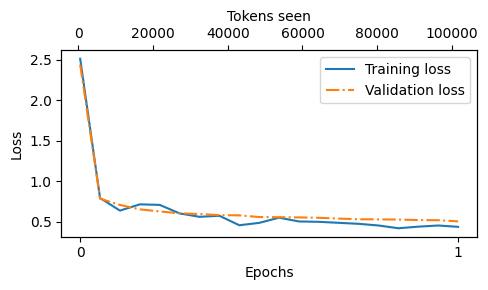

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Salvando respostas dos modelos (Finetunning e Base)
Obs: por limitações da execução local, essa etapa eu realizei no colab e depois baixei os resultados em json para o ambiente local

In [ ]:
torch.manual_seed(123)

model_without_finetuning = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model_without_finetuning, params)
model_without_finetuning.eval()
model_without_finetuning.to(device)

results = [] 

for entry in test_data:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    token_ids_wft = generate(
        model=model_without_finetuning,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )

    generated_text = token_ids_to_text(token_ids, tokenizer)
    generated_text_wft = token_ids_to_text(token_ids_wft, tokenizer)

    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    response_text_wft = (
        generated_text_wft[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    results.append({
        "instruction": entry["instruction"],
        "input": entry["input"],
        "output": entry["output"],
        "model 1 response": response_text,
        "model 2 response": response_text_wft
    })

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text}")
    print(f"\nModel without finetuning response:\n>> {response_text_wft.split('.')[0]}")
    print("-------------------------------------")

with open(r"data/model_responses.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Who wrote 'Sense and Sensibility'?

Correct response:
>> Jane Austen.

Model response:
>> Jane Austen.

Model without finetuning response:
>> The answer is:

The author of Sense and Sensibility
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Provide the plural form of 'cactus'.

Correct response:
>> The plural form of 'cactus' is 'cacti'.

Model response:
>> The plural form of 'cactus' is 'cacti'.

Model without finetuning response:
>> The response is a string of characters
-------------------------------------


KeyboardInterrupt: 

## LLM as a Judge

In [ ]:

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    # Send the POST request
    with requests.post(url, json=data, stream=True, timeout=30) as r:
        r.raise_for_status()
        response_data = ""
        for line in r.iter_lines(decode_unicode=True):
            if not line:
                continue
            response_json = json.loads(line)
            if "message" in response_json:
                response_data += response_json["message"]["content"]

    return response_data

result = query_model("What do Llamas eat? answer in 5 words.")
print(result)

Grass, hay, and plant fibers.


In [ ]:
json_file = r"data/model_responses.json"

with open(json_file, "r") as file:
    json_data = json.load(file)

print("Number of entries:", len(json_data))

Number of entries: 200


In [ ]:
results = []  # lista que vai conter todos os JSONs de avaliação

for i in tqdm(range(len(json_data))):
    entry = json_data[i]

    example_output = {
        "model_a": {
            "factual_correctness": 0,
            "instruction_adherence": 0,
            "clarity_and_usefulness": 0,
            "total": 0
        },
        "model_b": {
            "factual_correctness": 0,
            "instruction_adherence": 0,
            "clarity_and_usefulness": 0,
            "total": 0
        },
        "winner": "A | B | Tie",
        "justification": "Brief, objective comparison explaining the decision."
    }

    example_output_json = json.dumps(example_output, ensure_ascii=False, indent=2)

    prompt = f"""
You are an impartial LLM judge (ONLY ANSWER WITH JSON, DO NOT INTRODUCE UR ANSWER JUST SEND JSON TEXT ALONE).

Below are the details of a task and two model responses.

### Instruction
{entry['instruction']}

### Input
{format_input(entry)}

### Model A Response
{entry['model 1 response']}

### Model B Response
{entry['model 2 response']}

---

### Evaluation Criteria
For EACH model response, evaluate independently using the following criteria:

1. **Factual correctness** (0–5)
2. **Instruction adherence** (0–5)
3. **Clarity and usefulness** (0–5)

---

### Output Format (STRICT JSON)
{example_output_json}
"""

    judge_response = query_model(prompt)

    try:
        judge_json = json.loads(judge_response)
    except json.JSONDecodeError:
        # fallback caso o modelo retorne algo inválido
        judge_json = {
            "error": "Invalid JSON returned by judge",
            "raw_response": judge_response
        }

    # opcional: salvar metadados junto com a avaliação
    results.append({
        "instruction": entry["instruction"],
        "input": format_input(entry),
        "model_a_response": entry["model 1 response"],
        "model_b_response": entry["model 2 response"],
        "judge_evaluation": judge_json
    })

# salva tudo em um único arquivo
output_path = "data/llm_judge_results.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"\nResultados salvos em: {output_path}")

100%|██████████| 200/200 [1:55:50<00:00, 34.75s/it]


Resultados salvos em: llm_judge_results.json


## Modelo Small

Foi realizado o finetuning de um segundo modelo, esse limitando a somente 500 instruções (por limitações do ambiente local, foi realizado no colab e em seguida as respostas ao testes foram colocadas no ambiente local)

In [ ]:
import json
json_file_small = r"data/model_responses_small.json"

with open(json_file_small, "r") as file:
    json_data_small = json.load(file)

print("Number of entries:", len(json_data_small))

Number of entries: 50


## LLM as a Judge do modelo small

In [ ]:
results = []  # lista que vai conter todos os JSONs de avaliação

for i in tqdm(range(len(json_data_small))):
    entry = json_data_small[i]

    example_output = {
        "model_small": {
            "factual_correctness": 0,
            "instruction_adherence": 0,
            "clarity_and_usefulness": 0,
            "total": 0
        },
        "justification": "Brief, objective comparison explaining the decision."
    }

    example_output_json = json.dumps(example_output, ensure_ascii=False, indent=2)

    prompt = f"""
You are an impartial LLM judge (ONLY ANSWER WITH JSON, DO NOT INTRODUCE UR ANSWER JUST SEND JSON TEXT ALONE).

Below are the details of a task and two model responses.

### Instruction
{entry['instruction']}

### Input
{format_input(entry)}

### Model small Response
{entry['model small']}

---

### Evaluation Criteria
For EACH model response, evaluate independently using the following criteria:

1. **Factual correctness** (0–5)
2. **Instruction adherence** (0–5)
3. **Clarity and usefulness** (0–5)

---

### Output Format (STRICT JSON)
{example_output_json}
"""

    judge_response = query_model(prompt)

    try:
        judge_json = json.loads(judge_response)
    except json.JSONDecodeError:
        # fallback caso o modelo retorne algo inválido
        judge_json = {
            "error": "Invalid JSON returned by judge",
            "raw_response": judge_response
        }

    # opcional: salvar metadados junto com a avaliação
    results.append({
        "instruction": entry["instruction"],
        "input": format_input(entry),
        "model_small_response": entry["model small"],
        "judge_evaluation": judge_json
    })

# salva tudo em um único arquivo
output_path = r"data/llm_judge_results_small.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"\nResultados salvos em: {output_path}")

100%|██████████| 50/50 [11:14<00:00, 13.50s/it]


Resultados salvos em: llm_judge_results_small.json
